In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

from sklearn.preprocessing import OneHotEncoder

import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


# Loading Data
Below we are loading CIFAR10 dataset which has 50k train samples and 10k test samples.

In [2]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

170500096/170498071 [==============================] - 6s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

## Plotting First Few Images
Below we are plotting first 10 images from train dataset.

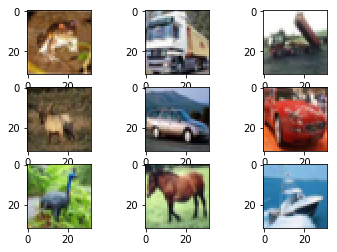

In [3]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

## Rescaling Data
Below we are dividing data of each image by 255 so that all values in all images stays between 0-1.0. In short we are rescaling image data between 0-1.0 so that training runs faster and converges fast.

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

## One Hot Encoding Of Targets
Below we are using `np_utils` module of `keras` to transform train/test targets to one hot encoded targets.

In [5]:
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
num_classes = Y_test.shape[1]

## Function For Plotting Train/Validation Accuracy & Loss per Epoch.
Below function takes as input history object generated by trained keras model which keeps tracks of loss and accuracy for train/validation sets and then plots it.

In [6]:
def plot_acc_loss(history):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,6))
        plt.subplot(121)
        plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Train Accuracy')
        #plt.scatter(range(len(history.history['accuracy'])), history.history['accuracy'])
        plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation accuracy')
        #plt.scatter(range(len(history.history['val_accuracy'])), history.history['val_accuracy'])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')

        plt.subplot(122)
        plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Train Loss')
        #plt.scatter(range(len(history.history['loss'])), history.history['loss'])
        plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
        #plt.scatter(range(len(history.history['val_loss'])), history.history['val_loss'])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')

# 1. Simple Convolutional Neural Network
Our first model is simple model with 2 convoluation layers.It has two convolutional layers followed by max pooling and a flattening out of the network to fully connected layers to make predictions.

1. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
2. Dropout set to 20%.
3. Convolutional layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
4. Max Pool layer with size 2×2.
5. Flatten layer.
6. Fully connected layer with 512 units and a rectifier activation function.
7. Dropout set to 50%.
8. Fully connected output layer with 10 units and a softmax activation function.

In [7]:
def conv_model_v1():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Compiling Model
Below we have initialized model with stochastic gradient descent and loss function of categorical crossentropy (logarithmic loss for multiclass problems). We have used accuracy is metrics of evaluation. SGD will be initialized with learning rate of 0.01.

In [8]:
model = conv_model_v1()
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

## Fitting Model
Below we are fitting our simple model to train data and evaluating its performance on test data for each epoch. We'll be running training for 25 epochs in total. Each epoch makes one full turn through all data samples. We'll be printing accuracy on test data as well once training completes.

In [9]:
%%time

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=32, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
 - 12s - loss: 1.7125 - accuracy: 0.3767 - val_loss: 1.4187 - val_accuracy: 0.4993
Epoch 2/25
 - 9s - loss: 1.3420 - accuracy: 0.5194 - val_loss: 1.2089 - val_accuracy: 0.5666
Epoch 3/25
 - 9s - loss: 1.1760 - accuracy: 0.5802 - val_loss: 1.1105 - val_accuracy: 0.6042
Epoch 4/25
 - 9s - loss: 1.0551 - accuracy: 0.6259 - val_loss: 1.0265 - val_accuracy: 0.6304
Epoch 5/25
 - 9s - loss: 0.9563 - accuracy: 0.6592 - val_loss: 0.9979 - val_accuracy: 0.6510
Epoch 6/25
 - 9s - loss: 0.8790 - accuracy: 0.6888 - val_loss: 0.9758 - val_accuracy: 0.6585
Epoch 7/25
 - 9s - loss: 0.8040 - accuracy: 0.7162 - val_loss: 0.9358 - val_accuracy: 0.6756
Epoch 8/25
 - 9s - loss: 0.7417 - accuracy: 0.7377 - val_loss: 0.9399 - val_accuracy: 0.6755
Epoch 9/25
 - 9s - loss: 0.6889 - accuracy: 0.7557 - val_loss: 0.9072 - val_accuracy: 0.6882
Epoch 10/25
 - 9s - loss: 0.6403 - accuracy: 0.7738 - val_loss: 0.9130 - val_accuracy: 0.6850
Epoch 11/25
 - 9s 

## Plotting Accuracy & Loss on Train/Validation Sets

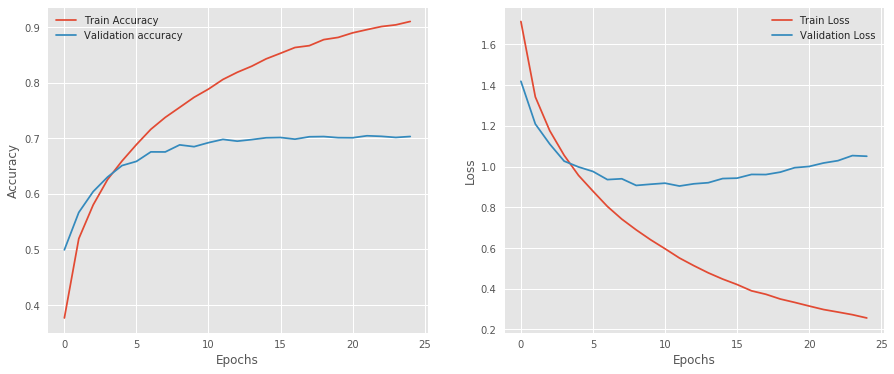

In [10]:
plot_acc_loss(history)

# 2. Large Convolutional Neural Network
As our previous simple model did not perform quite well, we'll try to introduce little complicated covolutional model. We'll be introducing more convolutional layers and following patters of 4 layers(Conv layer, Dropout layer, Conv layer, MaxPooling layer) with different input units (32,64,128). We'll then flatten output of last conv layer and feed it into Dense layers further.

Please find below architecture layers:

1. Convolutional input layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
2. Dropout layer at 20%.
3. Convolutional layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
4. Max Pool layer with size 2×2.
5. Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
6. Dropout layer at 20%.
7. Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
8. Max Pool layer with size 2×2.
9. Convolutional layer, 128 feature maps with a size of 3×3 and a rectifier activation function.
10. Dropout layer at 20%.
11. Convolutional layer,128 feature maps with a size of 3×3 and a rectifier activation function.
12. Max Pool layer with size 2×2.
13. Flatten layer.
14. Dropout layer at 20%.
15. Fully connected layer with 1024 units and a rectifier activation function.
16. Dropout layer at 20%.
17. Fully connected layer with 512 units and a rectifier activation function.
18. Dropout layer at 20%.
19. Fully connected output layer with 10 units and a softmax activation function.

In [11]:
def conv_model_v2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Compiling Model
Below we have initialized model with stochastic gradient descent and loss function of categorical crossentropy (logarithmic loss for multiclass problems). We have used accuracy is metrics of evaluation. SGD will be initialized with learning rate of 0.01.

In [12]:
model = conv_model_v2()
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)       

## Fitting Model
Below we are fitting our simple model to train data and evaluating its performance on test data for each epoch. We'll be running training for 25 epochs in total. Each epoch makes one full turn through all data samples. We'll be printing accuracy on test data as well once training completes.We are using batch size of 64 this time whereas we had used batch size of 32 last time.

In [13]:
%%time

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
 - 8s - loss: 1.9537 - accuracy: 0.2773 - val_loss: 1.6307 - val_accuracy: 0.4184
Epoch 2/25
 - 8s - loss: 1.5279 - accuracy: 0.4423 - val_loss: 1.4285 - val_accuracy: 0.4921
Epoch 3/25
 - 7s - loss: 1.3413 - accuracy: 0.5141 - val_loss: 1.2325 - val_accuracy: 0.5517
Epoch 4/25
 - 7s - loss: 1.2030 - accuracy: 0.5667 - val_loss: 1.1996 - val_accuracy: 0.5765
Epoch 5/25
 - 7s - loss: 1.0992 - accuracy: 0.6055 - val_loss: 1.0561 - val_accuracy: 0.6189
Epoch 6/25
 - 7s - loss: 1.0056 - accuracy: 0.6424 - val_loss: 0.9904 - val_accuracy: 0.6473
Epoch 7/25
 - 7s - loss: 0.9355 - accuracy: 0.6677 - val_loss: 0.8871 - val_accuracy: 0.6908
Epoch 8/25
 - 7s - loss: 0.8708 - accuracy: 0.6919 - val_loss: 0.8323 - val_accuracy: 0.7088
Epoch 9/25
 - 8s - loss: 0.8206 - accuracy: 0.7105 - val_loss: 0.8359 - val_accuracy: 0.7108
Epoch 10/25
 - 8s - loss: 0.7757 - accuracy: 0.7267 - val_loss: 0.7700 - val_accuracy: 0.7334
Epoch 11/25
 - 8s -

## Plotting Accuracy & Loss on Train/Validation Sets

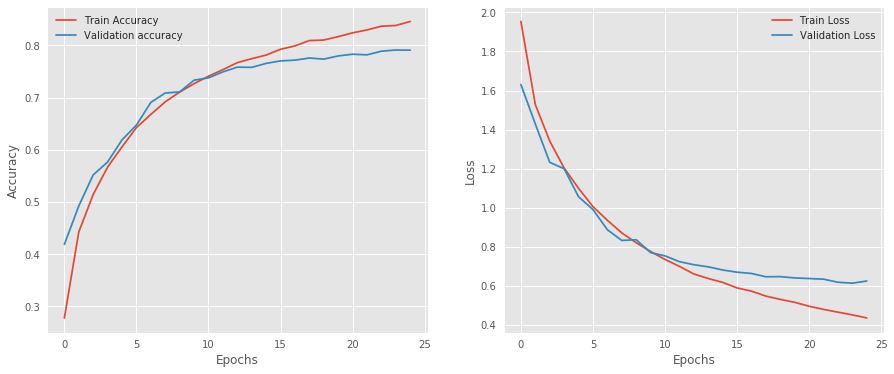

In [14]:
plot_acc_loss(history)

# 3. Large Conv Net with More Epochs
Below we have used same convolutional layer previous step but we are trying model for more epochs. We are trying model for 200 epochs this time. Apart from increasing more epochs, we have also introduced strategy called `ReduceLROnPlateau` which will reduce learning rate by factor of 0.1 if validation loss is not improving constantly for 100 epochs. We'll be training model with same 64 batch size.

In [15]:
%%time

model = conv_model_v2()
# Compile model
epochs = 200
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, verbose=0, callbacks=[reduce_lr])
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.10%
CPU times: user 21min 54s, sys: 6min 16s, total: 28min 10s
Wall time: 24min 43s


## Plotting Accuracy & Loss on Train/Validation Sets

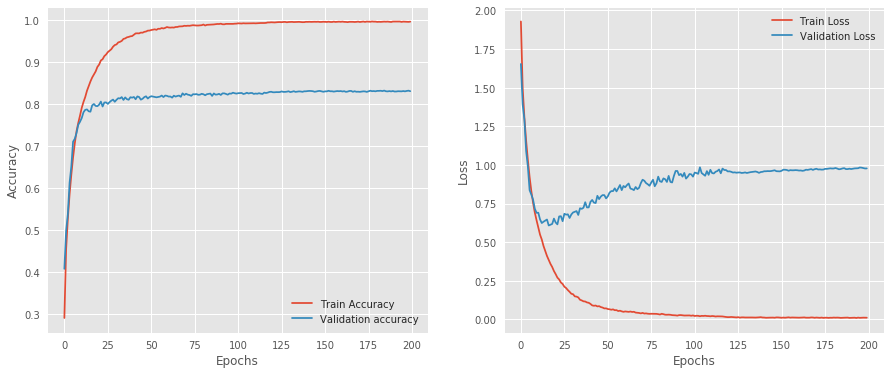

In [16]:
plot_acc_loss(history)

# 4. Large Conv Net with Data Augmentation
Below we are trying same convolutional neural network as previous step but now we have introduced data augmentation into our data which will make slight modification to images and create extra images for training. This will give model more images to train which can help it improve accuracy further. 

### Types of Data Augmentation:

**Image Rotation Angle:** Its degree by which image gets rotated. We have kept it to 30 degree as we don't won't to rotate much because real world images of some classes can't be upside down. Hence we have kept rotation to maximum of 30 degree.

**Horizontal Flip:** This will flip images horizontally.

**Zoom Range:** It range for zooming. We have kept it to 0.5 as we don't want to zoom much because our images are already small size (32 x 32 x 3).

**Height Shift Range:** It decides in what range height should be shifted. We have kept it to 0.15 which means we'll be shifting heights of images in 15% height of original image.

**Widht Shift Range:** It decides in what range height should be shifted. We have kept it to 0.15 which means we'll be shifting widths of images in 15% width of original image.

In [17]:
train_img_gen = ImageDataGenerator(rotation_range=30, width_shift_range=.15, height_shift_range=.15, horizontal_flip=True, zoom_range=0.5)
train_data_gen = train_img_gen.flow(X_train, Y_train, batch_size=64)

val_img_gen = ImageDataGenerator()
val_data_gen = val_img_gen.flow(X_test, Y_test, batch_size=128, shuffle=False)

We'll be running model again for 200 epochs and batch size will be 64. We have also used strategy called `ReduceLROnPlateau` which will reduce learning rate by factor of 0.1 if validation loss is not improving constantly for 100 epochs.

In [18]:
%%time

model = conv_model_v2()
# Compile model
epochs = 300
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
history = model.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=epochs, verbose=0, callbacks=[reduce_lr])
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.19%
CPU times: user 2h 35min 21s, sys: 6min 56s, total: 2h 42min 17s
Wall time: 2h 2min 17s


## Plotting Accuracy & Loss on Train/Validation Sets

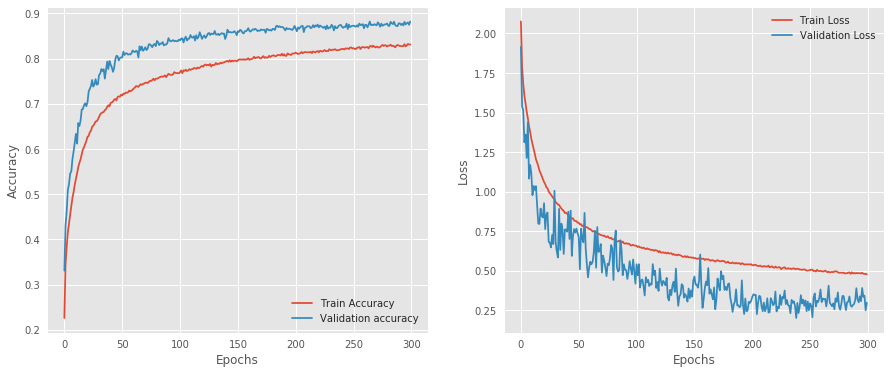

In [19]:
plot_acc_loss(history)

# 5. Large Convolutional Neural Net v2
Below we have introduced another version of convolutional neural network.. We'll be introducing few more convolutional layers and following patters of 4 layers(Conv layer, Dropout layer, Conv layer, MaxPooling layer) with different input units (32,64,128, 256). We'll then flatten output of last conv layer and feed it into Dense layers further.

Please find below architecture layers:

1. Convolutional input layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
2. Dropout layer at 20%.
3. Convolutional layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
4. Max Pool layer with size 2×2.
5. Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
6. Dropout layer at 20%.
7. Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
8. Max Pool layer with size 2×2.
9. Convolutional layer, 128 feature maps with a size of 3×3 and a rectifier activation function.
10. Dropout layer at 20%.
11. Convolutional layer,128 feature maps with a size of 3×3 and a rectifier activation function.
12. Max Pool layer with size 2×2.
13. Convolutional layer, 256 feature maps with a size of 3×3 and a rectifier activation function.
14. Dropout layer at 20%.
15. Convolutional layer,256 feature maps with a size of 3×3 and a rectifier activation function.
16. Max Pool layer with size 2×2.
17. Flatten layer.
18. Dropout layer at 20%.
19. Fully connected layer with 1024 units and a rectifier activation function.
20. Dropout layer at 20%.
21. Fully connected layer with 512 units and a rectifier activation function.
22. Dropout layer at 20%.
23. Fully connected output layer with 10 units and a softmax activation function.

In [20]:
def conv_model_v3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = conv_model_v3()
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)       

## Fitting Model
Below we are fitting our convolutional model v2 to train data and evaluating its performance on test data for each epoch. We'll be running training for 25 epochs in total. Each epoch makes one full turn through all data samples. We'll be printing accuracy on test data as well once training completes.We are using batch size of 64.

In [21]:
%%time

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, verbose=0, callbacks=[reduce_lr])
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 78.59%
CPU times: user 3min 1s, sys: 50.9 s, total: 3min 52s
Wall time: 3min 32s


## Plotting Accuracy & Loss on Train/Validation Sets

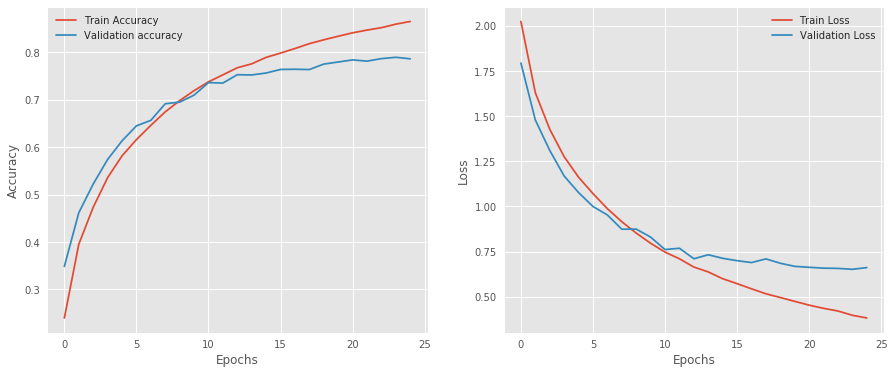

In [22]:
plot_acc_loss(history)

# 6. Large Conv Net v2 with Data Augmentation
Below we are tring our same large convolutional model v2 with data augmentation.

### Types of Data Augmentation:

**Image Rotation Angle:** Its degree by which image gets rotated. We have kept it to 30 degree as we don't won't to rotate much because real world images of some classes can't be upside down. Hence we have kept rotation to maximum of 30 degree.

**Horizontal Flip:** This will flip images horizontally.

**Zoom Range:** It range for zooming. We have kept it to 0.5 as we don't want to zoom much because our images are already small size (32 x 32 x 3).

**Height Shift Range:** It decides in what range height should be shifted. We have kept it to 0.15 which means we'll be shifting heights of images in 15% height of original image.

**Widht Shift Range:** It decides in what range height should be shifted. We have kept it to 0.15 which means we'll be shifting widths of images in 15% width of original image.

In [23]:
train_img_gen = ImageDataGenerator(rotation_range=30, width_shift_range=.15, height_shift_range=.15, horizontal_flip=True, zoom_range=0.5)
train_data_gen = train_img_gen.flow(X_train, Y_train, batch_size=64)

val_img_gen = ImageDataGenerator()
val_data_gen = val_img_gen.flow(X_test, Y_test, batch_size=128, shuffle=False)

## Fitting Model
Below we are fitting our convolutional model v2 to train data and evaluating its performance on test data for each epoch. We'll be running training for 200 epochs in total. Each epoch makes one full turn through all data samples. We'll be printing accuracy on test data as well once training completes.We are using batch size of 64.

In [24]:
%%time

model = conv_model_v3()
# Compile model
epochs = 300
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
history = model.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=epochs, verbose=0, callbacks=[reduce_lr])
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.99%
CPU times: user 2h 41min 3s, sys: 7min 27s, total: 2h 48min 31s
Wall time: 2h 4min 59s


## Plotting Accuracy & Loss on Train/Validation Sets

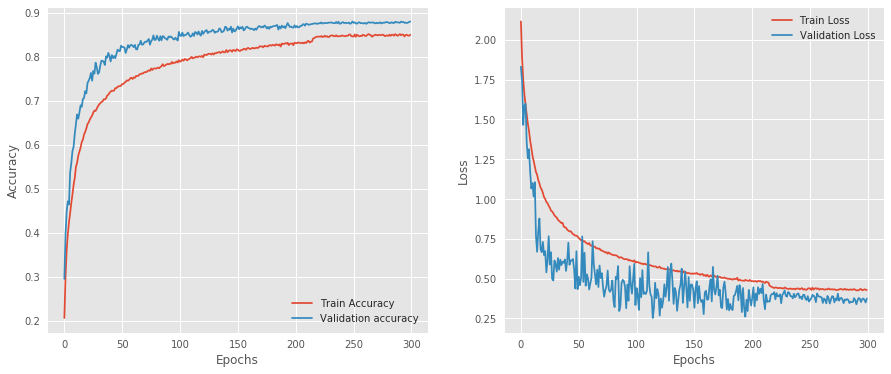

In [25]:
plot_acc_loss(history)